# PART 2
## Filter cells

Cells with low library size and low number of genes will be filtered out.

- **INPUT:**
    - ```$counts.RData``` 
    - ```anno_cells.RData```
    - ```anno_samples.RData```
    - ```anno_genes.RData```
    
- **NOTES:**

    The '_ctf' ending in the file names stands for cell type filter.
    
- **OUTPUT:**

    -  ```counts_cf.RData``` 
    -  ```anno_cells_cf.RData``` 
    -  ```anno_samples_cf.RData``` 
    -  ```anno_genes_cf.RData``` 

In [1]:
path_to_additional_files="../additional_input_files/"

In [2]:
library("ggplot2")

In [3]:
# load raw counts
load("../1.preprocess_data/outs/counts.RData")
print(dim(counts))

[1]  31843 211442


In [4]:
# load cell annotation
load("../1.preprocess_data/outs/anno_cells.RData")
rownames(anno_cells) <- anno_cells$cell_ID
print(str(anno_cells))

'data.frame':	58354 obs. of  75 variables:
 $ sample_ID          : chr  "AML-0024" "AML-0024" "AML-0024" "AML-0024" ...
 $ cell               : chr  "2020-09-15-AML0024:CATCAAGGTTAGCGGA" "2020-09-15-AML0024:CATCAAGTCCGAGAAG" "2020-09-15-AML0024:CATCCACAGGGACCAT" "2020-09-15-AML0024:CCTCAACAGAGCAAGA" ...
 $ UMAP_1             : num  -0.731 -2.2 -2.867 -1.666 -0.972 ...
 $ UMAP_2             : num  -15.8 -16.7 -16.1 -16.1 -17.5 ...
 $ orig.ident         : chr  "2020-09-15-AML0024" "2020-09-15-AML0024" "2020-09-15-AML0024" "2020-09-15-AML0024" ...
 $ samples            : chr  "AML0024" "AML0024" "AML0024" "AML0024" ...
 $ Broad_cell_identity: chr  "CD14+ monocyte" "CD14+ monocyte" "CD16+ monocyte" "CD14+ monocyte" ...
 $ Cell_type_identity : chr  "CD14+ IFN+" "CD14+" "CD16+" "CD14+ IFN+" ...
 $ clusters_res.2     : int  7 7 7 7 80 7 7 7 7 7 ...
 $ CNV_pos            : chr  "CNV+" "CNV+" "CNV+" "CNV+" ...
 $ malignant          : chr  "malignant" "malignant" "malignant" "malignant" ...
 $ a

In [5]:
# load sample annotation
load("../1.preprocess_data/outs/anno_samples.RData")
print(str(anno_samples))

'data.frame':	20 obs. of  53 variables:
 $ Sample.ID          : chr  "1" "2" "3" "4" ...
 $ sex                : chr  "F" "M" "F" "M" ...
 $ Age                : int  26 39 50 20 47 20 19 42 51 64 ...
 $ Sequencing         : chr  "CITE-Seq" "CITE-Seq" "CITE-Seq" "CITE-Seq" ...
 $ sample_ID          : chr  "healthy-1" "healthy-2" "healthy-3" "healthy-4" ...
 $ Institution        : chr  NA NA NA NA ...
 $ Manuscript.ID      : chr  NA NA NA NA ...
 $ Dx                 : chr  NA NA NA NA ...
 $ DxELN_Cytogenetic  : chr  NA NA NA NA ...
 $ Cytogenetics       : chr  NA NA NA NA ...
 $ Overall.survival   : int  NA NA NA NA NA NA NA NA NA 137 ...
 $ Flow.report.summary: chr  NA NA NA NA ...
 $ RAS.pathway        : chr  NA NA NA NA ...
 $ NPM1               : chr  NA NA NA NA ...
 $ IDH                : chr  NA NA NA NA ...
 $ TET2               : chr  NA NA NA NA ...
 $ TP53               : chr  NA NA NA NA ...
 $ RUNX1              : chr  NA NA NA NA ...
 $ CBF                : logi  NA NA N

In [6]:
# load gene annotation
load("../1.preprocess_data/outs/anno_genes.RData")
print(str(anno_genes))

'data.frame':	31843 obs. of  4 variables:
 $ gene_symbol      : chr  "MIR1302-2HG" "AL627309.1" "AL627309.3" "AL627309.5" ...
 $ is_in_LR_database: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ isLigand         : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ isReceptor       : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
NULL


### Process data

In [7]:
# check whether the cell IDs are the same in the counts and cell annotation files
cell_ID_overlap <- intersect(colnames(counts)
                             ,anno_cells$cell_ID)
print("str(cell_ID_overlap)")
print(str(cell_ID_overlap))

[1] "str(cell_ID_overlap)"
 chr [1:58354] "2019.07.01.count.1.AAACCCAAGACTCTTG" ...
NULL


In [8]:
# print out cells that are present in the raw counts, but not in the intersection
print(str(colnames(counts)[!(colnames(counts) %in% cell_ID_overlap)]))

 chr [1:153088] "2019.07.01.count.1.AAACCCACAAATGGCG" ...
NULL


In [9]:
# print out cells that present in the cell annotation, but not in the intersection
print(str(anno_cells$cell_ID[!(anno_cells$cell_ID %in% cell_ID_overlap)]))

 chr(0) 
NULL


### filter

In [10]:
# filter cells by their presence in the cell annotation file
counts_cf <- counts[,anno_cells$cell_ID]
print("nr cell before filtering")
print(ncol(counts))
print("nr cell after filtering")
print(ncol(counts_cf))

[1] "nr cell before filtering"
[1] 211442
[1] "nr cell after filtering"
[1] 58354


In [11]:
# calculate total counts
anno_cells$total_counts_raw <- colSums(counts_cf)
# calculate percent mito counts
print("calculate fraction of mito counts")
idx_mito_gene <- grepl("MT-", rownames(counts_cf))
anno_cells$mito_counts <- colSums(counts_cf[idx_mito_gene,])
anno_cells$frac_mito  <-  anno_cells$mito_counts / anno_cells$total_counts_raw

[1] "calculate fraction of mito counts"


In [12]:
# calculate nr genes
anno_cells$nr_genes <- colSums(counts_cf != 0)

### visualization

In [13]:
#cell filter thresholds
anno_cells$counts_upper_threshold <- 30000
anno_cells$counts_lower_threshold <- 1100
anno_cells$genes_lower_threshold <- 500

In [14]:
print(paste("counts_upper_threshold: <", anno_cells$counts_upper_threshold[1]))
print(paste("counts_lower_threshold: >",anno_cells$counts_lower_threshold[1]))
print(paste("genes_lower_threshold: >", anno_cells$genes_lower_threshold[1]))

[1] "counts_upper_threshold: < 30000"
[1] "counts_lower_threshold: > 1100"
[1] "genes_lower_threshold: > 500"


In [15]:
anno_cells$counts_upper_filter <- anno_cells$total_counts_raw < anno_cells$counts_upper_threshold
anno_cells$counts_lower_filter <- anno_cells$total_counts_raw > anno_cells$counts_lower_threshold
anno_cells$genes_lower_filter <- anno_cells$nr_genes > anno_cells$genes_lower_threshold
anno_cells$cell_filter <- anno_cells$counts_upper_filter & anno_cells$counts_lower_filter & 
        anno_cells$genes_lower_filter

'data.frame':	58354 obs. of  2 variables:
 $ log10_lib_size: num  3.41 3.41 3.43 3.44 3.45 ...
 $ sample_ID     : chr  "AML-0024" "AML-0024" "AML-0024" "AML-0024" ...
NULL


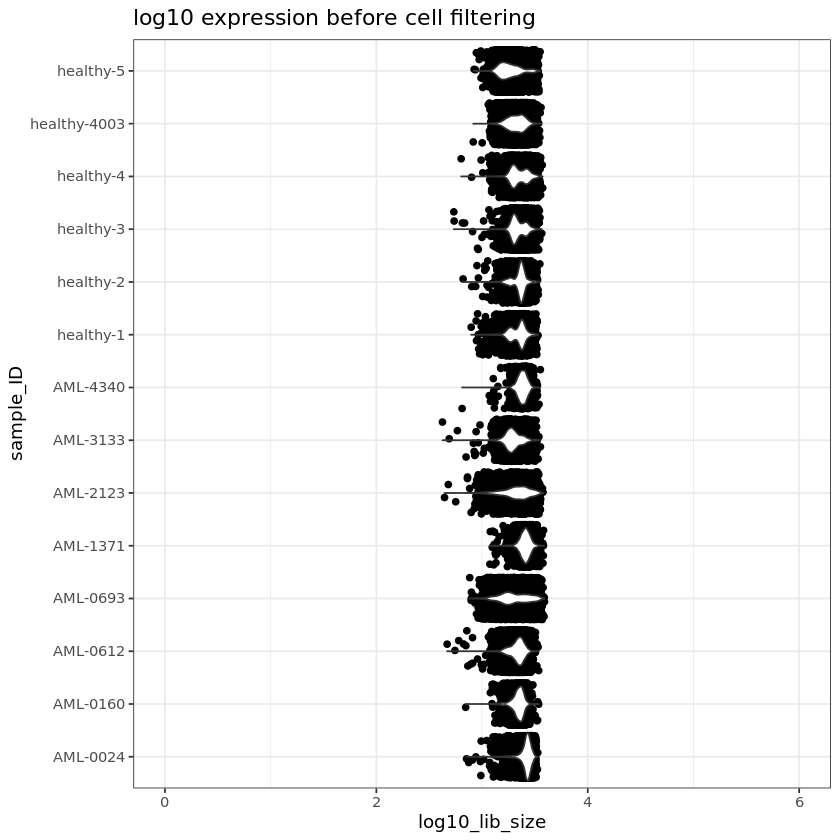

In [16]:
# visualize expression before any filtering
df <- data.frame(log10_lib_size = log10(anno_cells$total_counts_raw +1)
                 ,sample_ID = anno_cells$sample_ID
)
print(str(df))

print(ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression before cell filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()
)
rm(df)

Warning message:
“The dot-dot notation (`..level..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(level)` instead.”


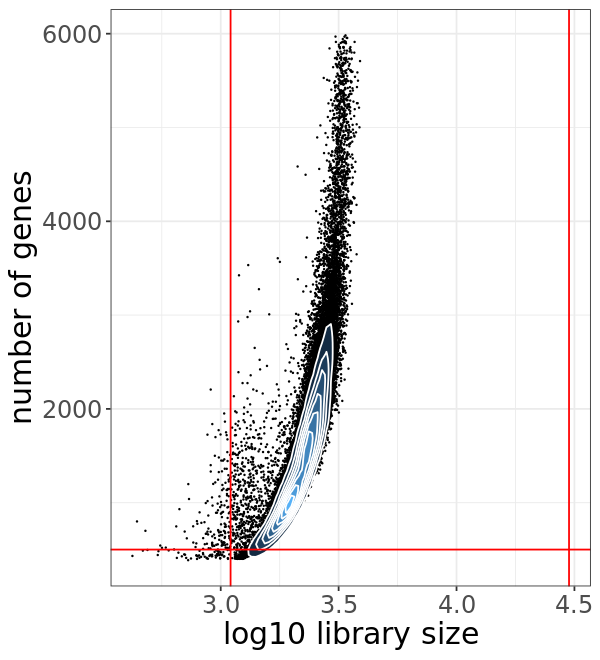

In [17]:
# plot log10 total counts vs nr genes
options(repr.plot.width = 5
       ,repr.plot.height = 5.5)

print(ggplot(data = anno_cells
             ,aes(x = log10(total_counts_raw +1)
                  ,y = nr_genes
             )
) +
      geom_point(size = 0.05) +
      stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white"
                     ,show.legend = FALSE) +
      geom_vline(xintercept = log10(c(1100,30000)+1)
                   ,col = "red") +
      geom_hline(yintercept = 500
                   ,col = "red") +
      theme_bw()+
      xlab("log10 library size")+
      ylab("number of genes")+
      theme(text = element_text(size = 18))  
)

In [18]:
#apply cell filters
anno_cells_cf <- anno_cells[anno_cells$cell_filter,]
print("before cell filtering:")
cat("dim(anno_cells)", dim(anno_cells),"\n")
print("after cell filtering:")
cat("dim(anno_cells_cf)", dim(anno_cells_cf),"\n")

[1] "before cell filtering:"
dim(anno_cells) 58354 86 
[1] "after cell filtering:"
dim(anno_cells_cf) 57420 86 


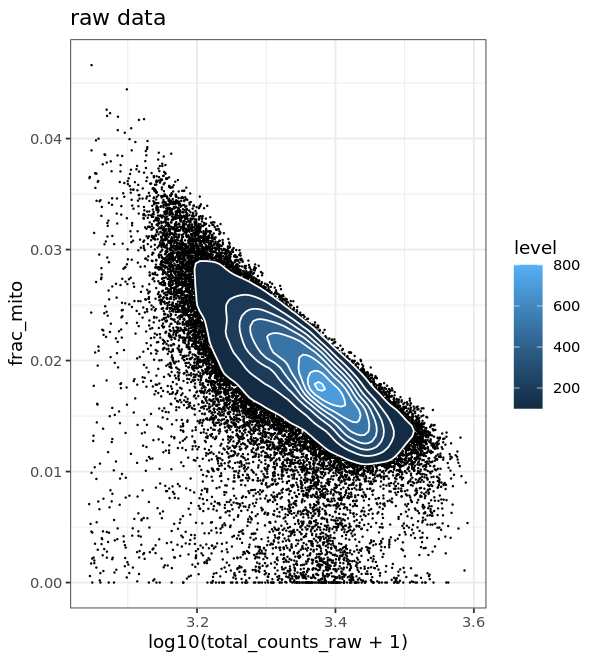

In [19]:
# plot log10 total counts vs fraction mito counts
print(ggplot(data = anno_cells_cf
             ,aes(x = log10(total_counts_raw +1)
                  ,y = frac_mito
             )
) +
        geom_point(size = 0.05) +
        stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
        ggtitle("raw data")+
        theme_bw()
)

In [20]:
# save cell number in anno_samples
for(sample in unique(anno_cells$sample_ID)){
        
        my_anno <- anno_cells[anno_cells$sample_ID == sample,]
        my_anno_cf <- anno_cells_cf[anno_cells_cf$sample_ID == sample,]
        
        anno_samples$nr_cells_raw[anno_samples$sample_ID == sample] <- nrow(my_anno)
        anno_samples$nr_cells_cf[anno_samples$sample_ID == sample] <- nrow(my_anno_cf)
}
cat("anno_samples\n\n")
print(anno_samples)

anno_samples

   Sample.ID sex Age           Sequencing    sample_ID Institution
1          1   F  26             CITE-Seq    healthy-1        <NA>
2          2   M  39             CITE-Seq    healthy-2        <NA>
3          3   F  50             CITE-Seq    healthy-3        <NA>
4          4   M  20             CITE-Seq    healthy-4        <NA>
5          5   M  47             CITE-Seq    healthy-5        <NA>
8         58   M  20             CITE-Seq   healthy-58        <NA>
9         82   M  19 CITE-Seq + scTCR-seq   healthy-82        <NA>
10      4003   M  42 CITE-Seq + scTCR-seq healthy-4003        <NA>
11       182   M  51            scTCR-seq  healthy-182        <NA>
12 U-06-0024   M  64             CITE-seq     AML-0024         OSU
13 U-11-0693   F  77 CITE-seq + scTCR-seq     AML-0693         OSU
14 U-15-2975   F  74            scTCR-seq     AML-2975         OSU
15 U-16-0160   M  74             CITE-seq     AML-0160         OSU
16 U-16-1133   F  78            scTCR-seq     AM

In [21]:
# subset counts
print("counts dim:")
print("before cell filtering:")
print(dim(counts_cf))
print("subset counts")
counts_cf <- counts_cf[,anno_cells_cf$cell_ID]
print("after cell filtering:")
print(dim(counts_cf))

[1] "counts dim:"
[1] "before cell filtering:"
[1] 31843 58354
[1] "subset counts"
[1] "after cell filtering:"
[1] 31843 57420


In [22]:
# visualize expression after cell filtering and before population size filtering
df <- data.frame(log10_lib_size = log10(anno_cells_cf$total_counts_raw +1)
                 ,sample_ID = anno_cells_cf$sample_ID
)
print(str(df))

'data.frame':	57420 obs. of  2 variables:
 $ log10_lib_size: num  3.41 3.41 3.43 3.44 3.45 ...
 $ sample_ID     : chr  "AML-0024" "AML-0024" "AML-0024" "AML-0024" ...
NULL


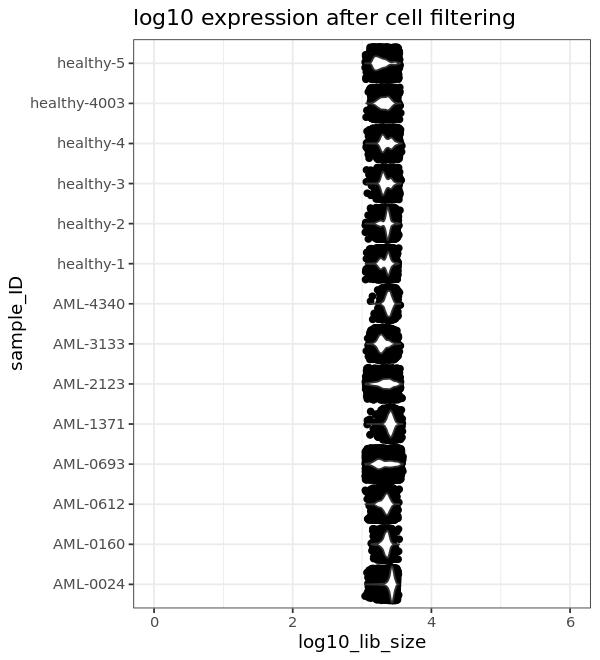

In [23]:
print(ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after cell filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()
)
rm(df)

In [24]:
anno_samples_cf <- anno_samples

anno_genes_cf <- anno_genes

### export

In [25]:
# # save counts_cf
# save(counts_cf, file = "counts_cf.RData")

# # save anno_cells_cf
# save(anno_cells_cf, file = "anno_cells_cf.RData")

# # save anno_samples_cf
# save(anno_samples_cf, file = "anno_samples_cf.RData")

# # save anno_genes_cf
# save(anno_genes_cf, file = "anno_genes_cf.RData")

In [26]:
unique(anno_cells_cf$sample_ID)

[1] "AML-0024"     "AML-0160"     "AML-0612"     "AML-0693"     "AML-1371"    
 [6] "AML-2123"     "AML-3133"     "AML-4340"     "healthy-1"    "healthy-2"   
[11] "healthy-3"    "healthy-4"    "healthy-4003" "healthy-5"

In [27]:
unique(anno_cells_cf$cell_type)

[1] "Mono"           "Gran"           "T"              "NK"            
 [5] "B"              "HSPC"           "Ery"            "DC"            
 [9] "LymP"           "Megakaryocytes" "PeriVasc"

In [28]:
unique(anno_samples$sample_ID)

[1] "healthy-1"    "healthy-2"    "healthy-3"    "healthy-4"    "healthy-5"   
 [6] "healthy-58"   "healthy-82"   "healthy-4003" "healthy-182"  "AML-0024"    
[11] "AML-0693"     "AML-2975"     "AML-0160"     "AML-1133"     "AML-2123"    
[16] "AML-3133"     "AML-0612"     "AML-0102"     "AML-1371"     "AML-4340"

## Filter cell types

Cell types which have too few cells (less than 5 cells) per sample or are present in too few samples (less than in 30 samples) will be filtered out.

- **INPUT:**
    - ```counts_cf.RData``` 
    - ```anno_cells_cf.RData```
    - ```anno_samples_cf.RData```
    - ```anno_genes_cf.RData```
    - ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
- **NOTES:**

    The '_ctf' ending in the file names stands for cell type filter.
    
- **OUTPUT:**

    -  ```counts_cf_ctf.RData``` 
    -  ```anno_cells_cf_ctf.RData``` 
    -  ```anno_samples_cf_ctf.RData``` 
    -  ```anno_genes_cf_ctf.RData``` 

In [29]:
# load cell relabelling file
print("load cell_relabelling")

file="../../cell_relabelling.csv"
cell_relabelling <- read.csv(file = paste(path_to_additional_files,file,sep="/")
                             ,sep = ";"
)

cell_relabelling <- cell_relabelling[cell_relabelling$source=="Lasry et al., 2022",]

# cell_relabelling <- cell_relabelling[!duplicated(cell_relabelling$cell_type_original),]
rownames(cell_relabelling) <- cell_relabelling$cell_type_original
print(cell_relabelling)

[1] "load cell_relabelling"
                  cell_type_original      cell_type             source
CD4+ T                        CD4+ T              T Lasry et al., 2022
CD8+ T                        CD8+ T              T Lasry et al., 2022
CD16+ monocyte        CD16+ monocyte           Mono Lasry et al., 2022
cDC2                            cDC2             DC Lasry et al., 2022
B                                  B              B Lasry et al., 2022
CD14+ monocyte        CD14+ monocyte           Mono Lasry et al., 2022
NK                                NK             NK Lasry et al., 2022
cDC1                            cDC1             DC Lasry et al., 2022
HLA-II+ monocyte    HLA-II+ monocyte           Mono Lasry et al., 2022
HSC                              HSC           HSPC Lasry et al., 2022
MAIT                            MAIT              T Lasry et al., 2022
CD11c+                        CD11c+           Mono Lasry et al., 2022
Pre-B                          Pre-B             

In [30]:
# thresholds ####
threshold_celltype_size <- 5 # cells per celltype
print(paste("Celltype size filter: each cell type in each sample should have at least", threshold_celltype_size, "cells."))

[1] "Celltype size filter: each cell type in each sample should have at least 5 cells."


In [31]:
threshold_nr_samples <-12 # nr of samples in which a cell type should be present
print(paste("Number of samples filter: each cell type should be present in at least", threshold_nr_samples, "samples."))

[1] "Number of samples filter: each cell type should be present in at least 12 samples."


In [32]:
# color scheme for celltypes
color_celltype <- cell_relabelling$cell_type_color_hex[!duplicated(cell_relabelling$cell_type)]
names(color_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]
print(color_celltype)

             T           Mono             DC              B             NK 
     "#4F92EE"      "#F09040"      "#854701"      "#4FC384"      "#4F64EE" 
          HSPC           Gran       PeriVasc           LymP            Ery 
     "#D040F0"      "#CD6600"      "#BEBEBE"      "#556B2F"      "#F72E3A" 
Megakaryocytes 
     "#C89B7A" 


In [33]:
# shape scheme for celltypes
shape_celltype <- cell_relabelling$cell_type_shape[!duplicated(cell_relabelling$cell_type)]
names(shape_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]
print(shape_celltype)

             T           Mono             DC              B             NK 
            12             13             15             12             17 
          HSPC           Gran       PeriVasc           LymP            Ery 
            12             15             17             12             19 
Megakaryocytes 
            13 


In [34]:
# shape scheme for sample IDs
shape_sample <- c(1:length(unique(anno_cells_cf$sample_ID)))
names(shape_sample) <- unique(anno_cells_cf$sample_ID)
print(shape_sample)

    AML-0024     AML-0160     AML-0612     AML-0693     AML-1371     AML-2123 
           1            2            3            4            5            6 
    AML-3133     AML-4340    healthy-1    healthy-2    healthy-3    healthy-4 
           7            8            9           10           11           12 
healthy-4003    healthy-5 
          13           14 


In [35]:
# size scheme for sample IDs
size_sample <- c(rep(3,8),rep(1,6))
names(size_sample) <- unique(anno_cells_cf$sample_ID)
print(size_sample)

    AML-0024     AML-0160     AML-0612     AML-0693     AML-1371     AML-2123 
           3            3            3            3            3            3 
    AML-3133     AML-4340    healthy-1    healthy-2    healthy-3    healthy-4 
           3            3            1            1            1            1 
healthy-4003    healthy-5 
           1            1 


### filter


In [36]:
# store threshold values in the cell annotation file
anno_cells_cf$threshold_celltype_size <- threshold_celltype_size

In [37]:
# calculate celltype size
for(sample in unique(anno_cells_cf$sample_ID)){
        idx_sample <- anno_cells_cf$sample_ID == sample
        
        for(celltype in unique(anno_cells_cf$cell_type)){
                idx_celltype <- anno_cells_cf$cell_type == celltype
                
                idx_sample_celltype <- idx_sample & idx_celltype
                
                anno_cells_cf$celltype_size_cf[idx_sample_celltype] <- nrow(anno_cells_cf[idx_sample_celltype,])
        }
}

In [38]:
# calculate celltype size filter
anno_cells_cf$celltype_size_filter <- anno_cells_cf$celltype_size_cf >= anno_cells_cf$threshold_celltype_size

In [39]:
unique(anno_cells_cf$cell_type)

[1] "Mono"           "Gran"           "T"              "NK"            
 [5] "B"              "HSPC"           "Ery"            "DC"            
 [9] "LymP"           "Megakaryocytes" "PeriVasc"

In [40]:
# visualize nr_samples vs log10_nr_cells before filtering
df <-unique(data.frame(sample_ID = anno_cells_cf$sample_ID
                       ,cell_type = anno_cells_cf$cell_type
                )
            )
print(df)
df$nr_cells <- sapply(1: nrow(df)
                      ,function(i){
                              my_sample <- df$sample_ID[i]
                              my_celltype <- df$cell_type[i]
                              nr_cells <- sum((anno_cells_cf$sample_ID == my_sample) & (anno_cells_cf$cell_type == my_celltype))
                              nr_cells
                      })
df$nr_samples <- sapply(1: nrow(df)
                        ,function(i){
                                my_celltype <- df$cell_type[i]
                                idx_celltype <- anno_cells_cf$cell_type == my_celltype
                                nr_samples <- length(unique(anno_cells_cf$sample_ID[idx_celltype]))
                                nr_samples
                        })

print(df)

         sample_ID      cell_type
1         AML-0024           Mono
10        AML-0024           Gran
34        AML-0024              T
55        AML-0024             NK
61        AML-0024              B
170       AML-0024           HSPC
477       AML-0024            Ery
1745      AML-0024             DC
6128      AML-0160           Mono
6133      AML-0160             DC
6138      AML-0160           Gran
6153      AML-0160           HSPC
6171      AML-0160              B
6175      AML-0160            Ery
6234      AML-0160              T
6620      AML-0160           LymP
7162      AML-0160             NK
7643      AML-0160 Megakaryocytes
8297      AML-0612           HSPC
8298      AML-0612              T
8349      AML-0612           Gran
8368      AML-0612             NK
8447      AML-0612           LymP
8668      AML-0612              B
8873      AML-0612            Ery
11122     AML-0612             DC
18284     AML-0693            Ery
18285     AML-0693              B
18286     AML-

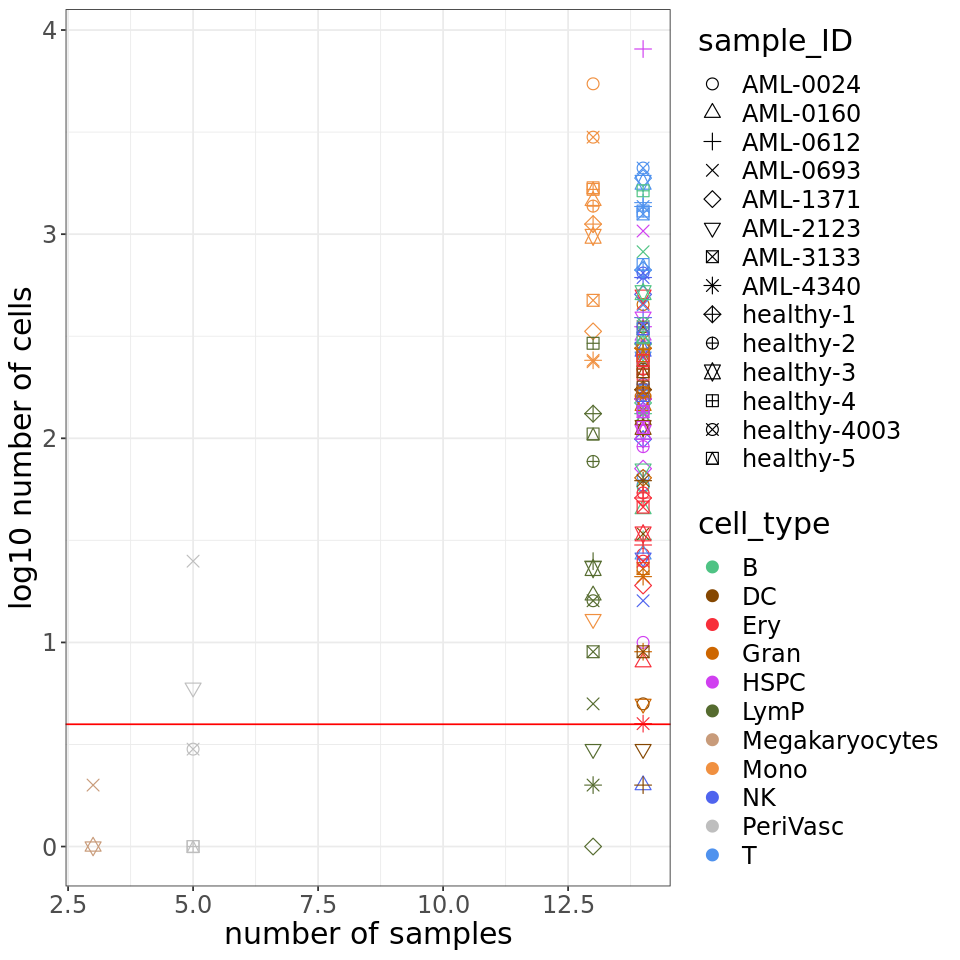

In [41]:
options(repr.plot.width = 8
       ,repr.plot.height = 8)

ggplot(data = df
       ,aes(x=nr_samples
            ,y=log10(nr_cells)
            ,color=cell_type
            ,shape=sample_ID
            ,size = sample_ID
            )
       )+
geom_point(size = 3)+
scale_color_manual(values=color_celltype)+
scale_shape_manual(values=shape_sample)+
scale_size_manual(values=size_sample)+
geom_hline(yintercept = log10(threshold_celltype_size)-0.1
           ,color = "red")+
theme_bw()+
xlab("number of samples")+
ylab("log10 number of cells")+
theme(text = element_text(size = 18))

In [42]:
# apply celltype size filter
# filter cell annotation file
anno_cells_cf_ctf <- anno_cells_cf[anno_cells_cf$celltype_size_filter,]
print("number of cells before celltype size filtering:")
print(nrow(anno_cells_cf))
print("number of cells after celltype size filtering:")
print(nrow(anno_cells_cf_ctf))

[1] "number of cells before celltype size filtering:"
[1] 57420
[1] "number of cells after celltype size filtering:"
[1] 57394


In [43]:
dim(anno_cells_cf)

[1] 57420    89

In [44]:
dim(counts_cf)

[1] 31843 57420

In [45]:
# x <- counts_cf[anno_cells_cf$celltype_size_filter,]

In [46]:
# dim(x)

In [47]:
# filer count matrix
counts_cf_ctf <- counts_cf[,anno_cells_cf$celltype_size_filter]
rm(counts_cf)

In [48]:
dim(counts_cf_ctf)

[1] 31843 57394

In [49]:
print("following cell types didn't pass the celltype size filter:")
for(sample in unique(anno_cells_cf_ctf$sample_ID)){
        print(sample)
        my_anno_cf <- anno_cells_cf[anno_cells_cf$sample_ID == sample,]
        print(table(my_anno_cf[!my_anno_cf$celltype_size_filter,"cell_type"]))
}

[1] "following cell types didn't pass the celltype size filter:"
[1] "AML-0024"
< table of extent 0 >
[1] "AML-0160"

Megakaryocytes             NK 
             1              2 
[1] "AML-0612"

DC 
 2 
[1] "AML-0693"

Megakaryocytes 
             2 
[1] "AML-1371"

LymP 
   1 
[1] "AML-2123"

            DC           LymP Megakaryocytes 
             3              3              1 
[1] "AML-3133"
< table of extent 0 >
[1] "AML-4340"

 Ery LymP 
   4    2 
[1] "healthy-1"
< table of extent 0 >
[1] "healthy-2"
< table of extent 0 >
[1] "healthy-3"
< table of extent 0 >
[1] "healthy-4"

PeriVasc 
       1 
[1] "healthy-4003"

PeriVasc 
       3 
[1] "healthy-5"

PeriVasc 
       1 


### filter for being present in the minimun number of samples

In [50]:
# visualize nr_samples vs log10_nr_cells_all_samples before filtering
df <-unique(data.frame(cell_type = anno_cells_cf_ctf$cell_type))

df$nr_cells_in_all_samples <- sapply(1: nrow(df)
                      ,function(i){
                              my_celltype <- df$cell_type[i]
                              nr_cells <- sum(anno_cells_cf_ctf$cell_type == my_celltype)
                              nr_cells
                      })

df$nr_samples <- sapply(1: nrow(df)
                        ,function(i){
                                my_celltype <- df$cell_type[i]
                                idx_celltype <- anno_cells_cf_ctf$cell_type == my_celltype
                                nr_samples <- length(unique(anno_cells_cf_ctf$sample_ID[idx_celltype]))
                                nr_samples
                        })

rownames(df) <- df$cell_type



In [51]:
anno_cells_cf_ctf[is.na(anno_cells_cf_ctf$cel_type), ]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


sample_ID,cell,UMAP_1,UMAP_2,orig.ident,samples,Broad_cell_identity,Cell_type_identity,clusters_res.2,CNV_pos,⋯,counts_upper_threshold,counts_lower_threshold,genes_lower_threshold,counts_upper_filter,counts_lower_filter,genes_lower_filter,cell_filter,threshold_celltype_size,celltype_size_cf,celltype_size_filter
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<int>,<lgl>


In [52]:
anno_cells_cf_ctf[anno_cells_cf_ctf$cel_type=="NA",]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


sample_ID,cell,UMAP_1,UMAP_2,orig.ident,samples,Broad_cell_identity,Cell_type_identity,clusters_res.2,CNV_pos,⋯,counts_upper_threshold,counts_lower_threshold,genes_lower_threshold,counts_upper_filter,counts_lower_filter,genes_lower_filter,cell_filter,threshold_celltype_size,celltype_size_cf,celltype_size_filter
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<int>,<lgl>


In [53]:
unique(anno_cells_cf_ctf$cell_type)

[1] "Mono"     "Gran"     "T"        "NK"       "B"        "HSPC"    
 [7] "Ery"      "DC"       "LymP"     "PeriVasc"

In [54]:
df$cell_type

[1] "Mono"     "Gran"     "T"        "NK"       "B"        "HSPC"    
 [7] "Ery"      "DC"       "LymP"     "PeriVasc"

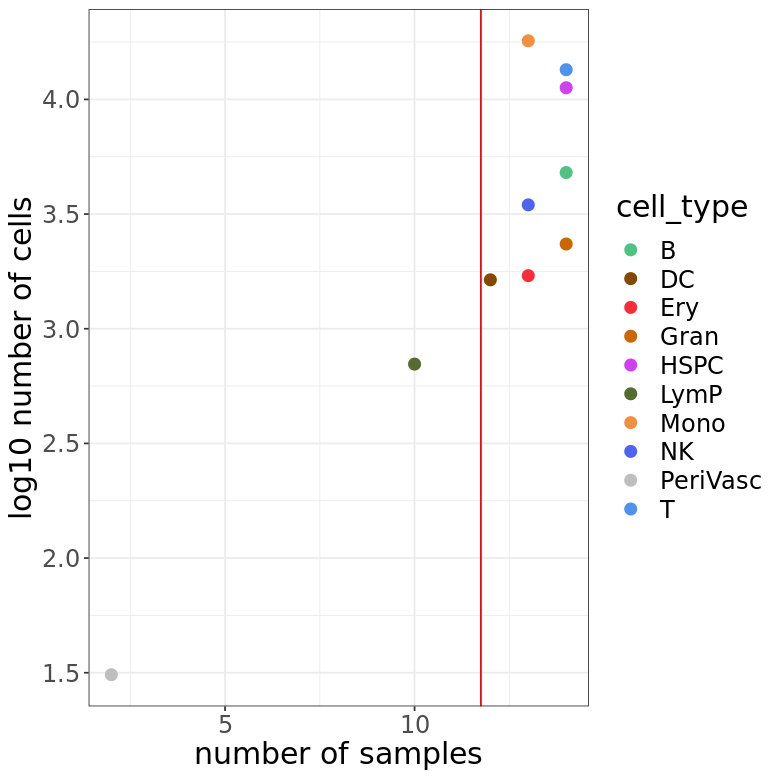

In [55]:
options(repr.plot.width = 6.5
       ,repr.plot.height = 6.5)

ggplot(data = df
       ,aes(x = nr_samples
            ,y = log10(nr_cells_in_all_samples)
            ,color = cell_type
       )
) +
geom_point(size = 3) +
scale_color_manual(values = color_celltype) +
geom_vline(xintercept = threshold_nr_samples-0.25
           ,color = "red")+
theme_bw()+
ylab("log10 number of cells")+
xlab("number of samples")+
theme(text = element_text(size = 18))

### filter out underrepresented cell types

In [56]:
print(paste("filter out celltypes present in less than"
             ,threshold_nr_samples
             ,"samples"))
print("following celltypes didn' pass the filter")
bad_celltypes <- rownames(df)[df$nr_samples < threshold_nr_samples]
print(bad_celltypes)

[1] "filter out celltypes present in less than 12 samples"
[1] "following celltypes didn' pass the filter"
[1] "LymP"     "PeriVasc"


In [57]:
print("dim(counts_cf_ctf) before filtering")
print(dim(counts_cf_ctf))
counts_cf_ctf <- counts_cf_ctf[,!(anno_cells_cf_ctf$cell_type %in% bad_celltypes)]
print("dim(counts_cf_ctf) after filtering")
print(dim(counts_cf_ctf))
print("dim(anno_cells_cf_ctf) before filtering")
print(dim(anno_cells_cf_ctf))
anno_cells_cf_ctf <- anno_cells_cf_ctf[!(anno_cells_cf_ctf$cell_type %in% bad_celltypes),]
print("dim(anno_cells_cf_ctf) after filtering")
print(dim(anno_cells_cf_ctf))

[1] "dim(counts_cf_ctf) before filtering"
[1] 31843 57394
[1] "dim(counts_cf_ctf) after filtering"
[1] 31843 56662
[1] "dim(anno_cells_cf_ctf) before filtering"
[1] 57394    89
[1] "dim(anno_cells_cf_ctf) after filtering"
[1] 56662    89


In [58]:
# visualize expression after cell filtering and celltype size filtering
print("visualize expression after cell filtering and celltype size filtering")
df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf$total_counts_raw +1)
                 ,sample_ID = anno_cells_cf_ctf$sample_ID
)
print(str(df))

[1] "visualize expression after cell filtering and celltype size filtering"
'data.frame':	56662 obs. of  2 variables:
 $ log10_lib_size: num  3.41 3.41 3.43 3.44 3.45 ...
 $ sample_ID     : chr  "AML-0024" "AML-0024" "AML-0024" "AML-0024" ...
NULL


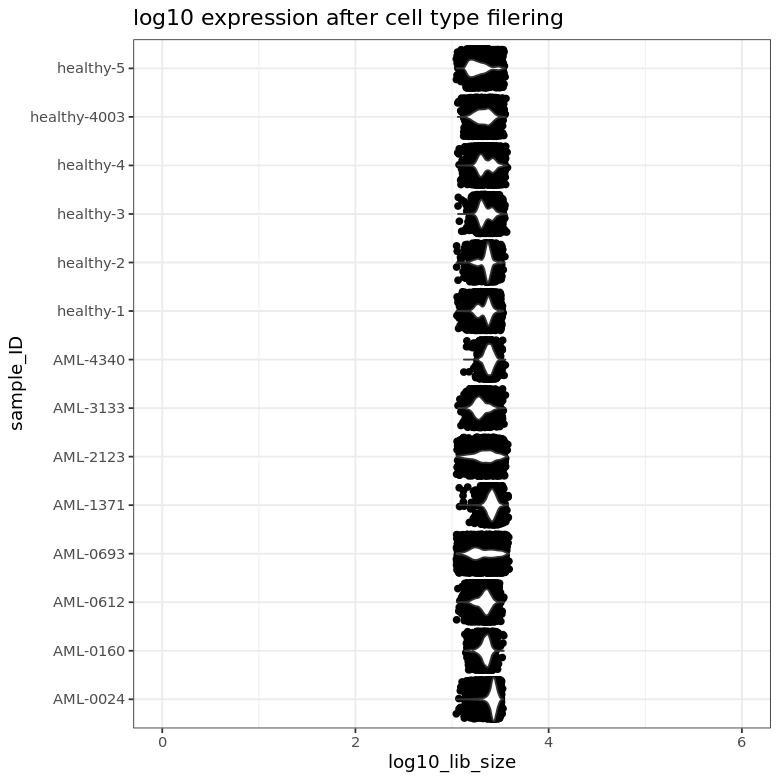

In [59]:
ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after cell type filering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

In [60]:
# create anno_samples_cf_ctf
anno_samples_cf_ctf <- anno_samples_cf

In [61]:
# save cell number in anno_samples
for(sample in unique(anno_cells_cf_ctf$sample_ID)){
        
        my_anno_cf <- anno_cells_cf_ctf[anno_cells_cf_ctf$sample_ID == sample,]
        
        anno_samples_cf_ctf$nr_cells_cf_ctf[anno_samples_cf_ctf$sample_ID == sample] <- nrow(my_anno_cf)
}
print("anno_samples_cf_ctf")
print(anno_samples_cf_ctf)

[1] "anno_samples_cf_ctf"
   Sample.ID sex Age           Sequencing    sample_ID Institution
1          1   F  26             CITE-Seq    healthy-1        <NA>
2          2   M  39             CITE-Seq    healthy-2        <NA>
3          3   F  50             CITE-Seq    healthy-3        <NA>
4          4   M  20             CITE-Seq    healthy-4        <NA>
5          5   M  47             CITE-Seq    healthy-5        <NA>
8         58   M  20             CITE-Seq   healthy-58        <NA>
9         82   M  19 CITE-Seq + scTCR-seq   healthy-82        <NA>
10      4003   M  42 CITE-Seq + scTCR-seq healthy-4003        <NA>
11       182   M  51            scTCR-seq  healthy-182        <NA>
12 U-06-0024   M  64             CITE-seq     AML-0024         OSU
13 U-11-0693   F  77 CITE-seq + scTCR-seq     AML-0693         OSU
14 U-15-2975   F  74            scTCR-seq     AML-2975         OSU
15 U-16-0160   M  74             CITE-seq     AML-0160         OSU
16 U-16-1133   F  78            scTC

In [62]:
# create anno_gene_cf_ctf
anno_genes_cf_ctf <- anno_genes_cf

### export

In [63]:
# #save counts_cf_ctf.RData
# save(counts_cf_ctf, file = "counts_cf_ctf.RData")

# #save anno_cells_cf_ctf.RData
# save(anno_cells_cf_ctf, file = "anno_cells_cf_ctf.RData")

# #save anno_samples_cf_ctf.RData
# save(anno_samples_cf_ctf, file = "anno_samples_cf_ctf.RData")

# #save anno_genes_cf_ctf.RData
# save(anno_genes_cf_ctf, file = "anno_genes_cf_ctf.RData")

## Filter genes

Individual genes might be specific to certain cell types in certain health conditions. Here we will construct pseudo-bulk cell types (per sample) and filter out genes that have too low cumulative expression in these pseudo-bulks.

- **INPUT:**
    - ```counts_cf_ctf.RData``` 
    - ```anno_cells_cf_ctf.RData```
    - ```anno_samples_cf_ctf.RData```
    - ```anno_genes_cf_ctf.RData```
    - ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
    
- **NOTES:**

    The '_gf' ending in the file names stands for gene filter.
    
    
- **OUTPUT:**

    -  ```counts_cf_ctf_gf.RData```
    -  ```anno_cells_cf_ctf_gf.RData```
    -  ```anno_samples_cf_ctf_gf.RData```
    -  ```anno_genes_cf_ctf_gf.RData```

In [64]:
rownames(cell_relabelling) <- cell_relabelling$cell_type_original
print(str(cell_relabelling))

'data.frame':	27 obs. of  9 variables:
 $ cell_type_original    : chr  "CD4+ T" "CD8+ T" "CD16+ monocyte" "cDC2" ...
 $ cell_type             : chr  "T" "T" "Mono" "DC" ...
 $ source                : chr  "Lasry et al., 2022" "Lasry et al., 2022" "Lasry et al., 2022" "Lasry et al., 2022" ...
 $ cell_type_color       : chr  "blue" "blue" "darkorange" "brown" ...
 $ cell_type_color_hex   : chr  "#4F92EE" "#4F92EE" "#F09040" "#854701" ...
 $ cell_type_shape       : int  12 12 13 15 12 13 17 15 13 12 ...
 $ cell_subtype          : chr  "CD4_T" "CD8_T" "Mono" "cDC" ...
 $ cell_subtype_color    : chr  "lightblue" "blue" "darkorange" "brown" ...
 $ cell_subtype_color_hex: chr  "#4FCCEE" "#4F92EE" "#F09040" "#B95D10" ...
NULL


In [65]:
# thresholds
threshold_sum_pseudobulkCellType_expr <- 0.25
print(paste("threshold_sum_pseudobulkCellType_expr: >", threshold_sum_pseudobulkCellType_expr))

[1] "threshold_sum_pseudobulkCellType_expr: > 0.25"


In [66]:
# color scheme for celltypes
color_celltype <- cell_relabelling$cell_type_color_hex[!duplicated(cell_relabelling$cell_type)]
names(color_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]

### process data

In [67]:
# construct pseudo sorted bulk

anno_cells_cf_ctf$cell_type_ID <- paste(anno_cells_cf_ctf$cell_type
                                        ,anno_cells_cf_ctf$sample_ID
                                        ,sep = "_"
)

In [68]:
cell_type_IDs <- unique(anno_cells_cf_ctf$cell_type_ID)
counts_raw_pseudobulkCellType <- as.data.frame(matrix(,nrow = nrow(counts_cf_ctf)
                                                    ,ncol = length(cell_type_IDs)
))

i <- 1
for(cell_type_ID in cell_type_IDs){
        #print(cell_type_ID)
        
        idx_cell_type_ID <- anno_cells_cf_ctf$cell_type_ID == cell_type_ID
        
        if(sum(idx_cell_type_ID) == 0){
                counts_raw_pseudobulkCellType[,i] <- 0
        } else if( sum(idx_cell_type_ID) == 1){
                counts_raw_pseudobulkCellType[,i] <- counts_cf_ctf[,idx_cell_type_ID]
        } else {
                counts_raw_pseudobulkCellType[,i] <- rowMeans(counts_cf_ctf[,idx_cell_type_ID])
        }
        
        i <- i+1
}

colnames(counts_raw_pseudobulkCellType) <- cell_type_IDs
rownames(counts_raw_pseudobulkCellType) <- rownames(counts_cf_ctf)
cat("str(counts_raw_pseudobulkCellType\n\n)")
print(str(counts_raw_pseudobulkCellType))

str(counts_raw_pseudobulkCellType

)'data.frame':	31843 obs. of  107 variables:
 $ Mono_AML-0024    : num  0 0.000884 0.000103 0.010334 0.000136 ...
 $ Gran_AML-0024    : num  0 0 0 0.009065 0.000844 ...
 $ T_AML-0024       : num  0 0 0 0 0 ...
 $ NK_AML-0024      : num  0 0 0 0 0 ...
 $ B_AML-0024       : num  0 0 0 0 0 ...
 $ HSPC_AML-0024    : num  0 0 0 0 0 ...
 $ Ery_AML-0024     : num  0 0 0 0 0 ...
 $ DC_AML-0024      : num  0 0 0 0 0 ...
 $ Mono_AML-0160    : num  0 0 0 0.00817 0 ...
 $ DC_AML-0160      : num  0 0 0 0 0 ...
 $ Gran_AML-0160    : num  0 0 0 0.00702 0 ...
 $ HSPC_AML-0160    : num  0 0 0 0.0105 0 ...
 $ B_AML-0160       : num  0 0 0 0 0 ...
 $ Ery_AML-0160     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ T_AML-0160       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ HSPC_AML-0612    : num  0 0.000573 0 0.012395 0.000642 ...
 $ T_AML-0612       : num  0 0 0 0.00625 0.00273 ...
 $ Gran_AML-0612    : num  0 0 0 0 0 ...
 $ NK_AML-0612      : num  0 0.00453 0 0.00802 0 ...
 $ B_AML-0612    

### visualize possible filtering parameters

In [69]:
nr_expressing_cell_types <- rowSums(counts_raw_pseudobulkCellType != 0)

anno_genes_cf_ctf$sum_pseudobulkCellType_expr = rowSums(as.matrix(counts_raw_pseudobulkCellType))
anno_genes_cf_ctf$sum_pseudobulkCellType_expr_threshold <- rep(threshold_sum_pseudobulkCellType_expr, nrow(anno_genes_cf_ctf))
anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter <- anno_genes_cf_ctf$sum_pseudobulkCellType_expr > threshold_sum_pseudobulkCellType_expr
print(str(anno_genes_cf_ctf))

'data.frame':	31843 obs. of  7 variables:
 $ gene_symbol                          : chr  "MIR1302-2HG" "AL627309.1" "AL627309.3" "AL627309.5" ...
 $ is_in_LR_database                    : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ isLigand                             : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ isReceptor                           : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ sum_pseudobulkCellType_expr          : num  0 0.1613 0.0159 0.7471 0.0314 ...
 $ sum_pseudobulkCellType_expr_threshold: num  0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...
 $ sum_pseudobulkCellType_expr_filter   : logi  FALSE FALSE FALSE TRUE FALSE FALSE ...
NULL


In [70]:
print(paste("we have"
            ,nrow(counts_cf_ctf)
            ,"genes before filtering"
)
)
print(paste("we have"
            ,sum(anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter)
            ,"genes after filtering"
)
)

[1] "we have 31843 genes before filtering"
[1] "we have 15770 genes after filtering"


In [71]:
# plot sum expression vs nr expressing pseudobulk cell types
df <- data.frame(log10_sum_expr = log10(rowSums(as.matrix(counts_raw_pseudobulkCellType)) +1)
                 ,nr_expressing_pseudobulkCellTypes = nr_expressing_cell_types
                 ,passed_gene_filter = anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter
)


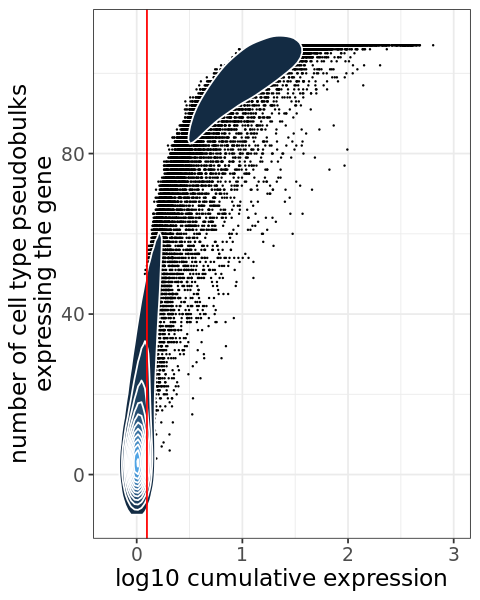

In [72]:
options(repr.plot.width = 4
       ,repr.plot.height = 5)
ggplot(data = df
             ,aes(x = log10_sum_expr
                  ,y = nr_expressing_pseudobulkCellTypes
             )
) +
geom_point(size = 0.05)+
ylim(c(-10,110))+
xlim(c(-0.25,3))+
ylab("number of cell type pseudobulks\nexpressing the gene")+
xlab("log10 cumulative expression")+
stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white"
               ,show.legend = FALSE) +
geom_vline(xintercept = log10(threshold_sum_pseudobulkCellType_expr+1), color = "red")+
theme_bw()+
theme(text = element_text(size = 14))

### filter genes

In [73]:
# filter genes by gene filter from the gene annotation file
counts_cf_ctf_gf <- counts_cf_ctf[anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter,]
print(dim(counts_cf_ctf_gf))

[1] 15770 56662


In [74]:
# filter gene annotation by gene filter from the gene annotation file
anno_genes_cf_ctf_gf <- anno_genes_cf_ctf[anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter,]

In [75]:
# store total counts per cell after gene filtering in the cell annotation file
anno_cells_cf_ctf_gf <- anno_cells_cf_ctf
anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf <- colSums(counts_cf_ctf_gf)

In [76]:
anno_samples_cf_ctf_gf <- anno_samples_cf_ctf

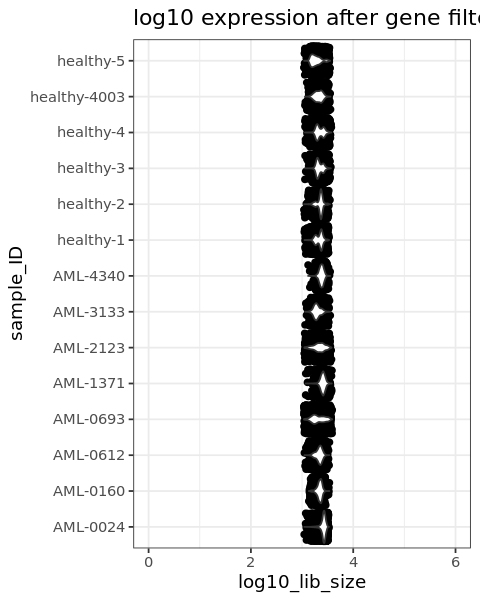

In [77]:
# visualize the expression after gene filter
df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf +1)
                 ,sample_ID = anno_cells_cf_ctf_gf$sample_ID
)

ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after gene filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

### export

In [78]:
# #save counts_cf_ctf_gf.RData
# save(counts_cf_ctf_gf, file = "counts_cf_ctf_gf.RData")

# #save anno_cells_cf_ctf_gf.RData
# save(anno_cells_cf_ctf_gf, file = "anno_cells_cf_ctf_gf.RData")

# #save anno_samples_cf_ctf_gf.RData
# save(anno_samples_cf_ctf_gf, file = "anno_samples_cf_ctf_gf.RData")
# 3
# #save anno_genes_cf_ctf_gf.RData
# save(anno_genes_cf_ctf_gf, file = "anno_genes_cf_ctf_gf.RData")

## Filter samples

Samples with less than 5 cell types will be filtered out.

- **INPUT:**
    - ```counts_cf_ctf_gf.RData``` 
    - ```anno_cells_cf_ctf_gf.RData```
    - ```anno_samples_cf_ctf_gf.RData```
    - ```anno_genes_cf_ctf_gf.RData```
    
- **NOTES:**

    The '_sf' ending in the file names stands for sample filter.
    
- **OUTPUT:**

    -  ```counts_cf_ctf_gf_sf.RData``` 
    -  ```anno_cells_cf_ctf_gf_sf.RData``` 
    -  ```anno_samples_cf_ctf_gf_sf.RData```
    -  ```anno_genes_cf_ctf_gf_sf.RData```

In [79]:
# print("load counts")
# load("./AML_healthy/counts_cf_ctf_gf.RData")
# print("dim(counts_cf_ctf_gf)")
# print(dim(counts_cf_ctf_gf))

# # load cell annotation
# print("load cell annotation")
# load("./AML_healthy/anno_cells_cf_ctf_gf.RData")
# print("str(anno_cells_cf_ctf_gf)")
# print(str(anno_cells_cf_ctf_gf))

# # load sample annotation
# print("load sample annotation")
# load("./AML_healthy/anno_samples_cf_ctf_gf.RData")
# print("str(anno_samples_cf_ctf_gf)")
# print(str(anno_samples_cf_ctf_gf))

# # load gene annotation
# print("load gene annotation")
# load("./AML_healthy/anno_genes_cf_ctf_gf.RData")
# print("str(anno_genes_cf_ctf_gf)")
# print(str(anno_genes_cf_ctf_gf))

In [80]:
# thresholds ####
threshold_nr_celltypes <- 7
print(paste("A sample should contain at least"
            ,threshold_nr_celltypes
            ,"cell types"))

[1] "A sample should contain at least 7 cell types"


### filter

In [81]:
# filter out samples that are not present in the cell annotation
print(dim(anno_samples_cf_ctf_gf))
anno_samples_cf_ctf_gf <- anno_samples_cf_ctf_gf[anno_samples_cf_ctf_gf$sample_ID %in% unique(anno_cells_cf_ctf_gf$sample_ID),]
print(dim(anno_samples_cf_ctf_gf))

[1] 20 56
[1] 14 56


In [82]:
rownames(anno_samples_cf_ctf_gf) <- anno_samples_cf_ctf_gf$sample_ID
anno_samples_cf_ctf_gf <- anno_samples_cf_ctf_gf[unique(anno_cells_cf_ctf_gf$sample_ID),]
print(dim(anno_samples_cf_ctf_gf))

[1] 14 56


In [83]:
# store total counts per sample after gene filtering in the sample annotation file
anno_samples_cf_ctf_gf$total_counts_raw_cf_ctf_gf <- sapply(unique(anno_cells_cf_ctf_gf$sample_ID)
                                                         ,function(sample){
                                                             #print(sample)
                                                                 idx_sample <- anno_cells_cf_ctf_gf$sample_ID == sample
                                                             #print(sum(idx_sample))
                                                                 sum(anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf[idx_sample])
                                                         })

In [84]:
# store number of cell types per sample after gene filtering in the sample annotation file
anno_samples_cf_ctf_gf$nr_celltypes_cf_ctf_gf <- sapply(anno_samples_cf_ctf_gf$sample_ID
                                                         ,function(sample){
                                                                 idx_sample <- anno_cells_cf_ctf_gf$sample_ID == sample
                                                                 length(unique(anno_cells_cf_ctf_gf$cell_type[idx_sample]))
                                                         })

In [85]:
anno_samples_cf_ctf_gf$threshold_nr_celltypes <- paste("greater or equal"
                                              ,threshold_nr_celltypes)
anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes <- anno_samples_cf_ctf_gf$nr_celltypes_cf_ctf_gf >= threshold_nr_celltypes


In [86]:
print(paste("we have"
            ,sum(anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes)
            ,"samples that passed the threshold"))
print(paste("we have"
            ,sum(!anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes)
            ,"samples that didn't pass the threshold:"))

[1] "we have 13 samples that passed the threshold"
[1] "we have 1 samples that didn't pass the threshold:"


In [87]:
bad_samples <- anno_samples_cf_ctf_gf$sample_ID[!anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes]
print(bad_samples)

[1] "AML-0612"


### visualization

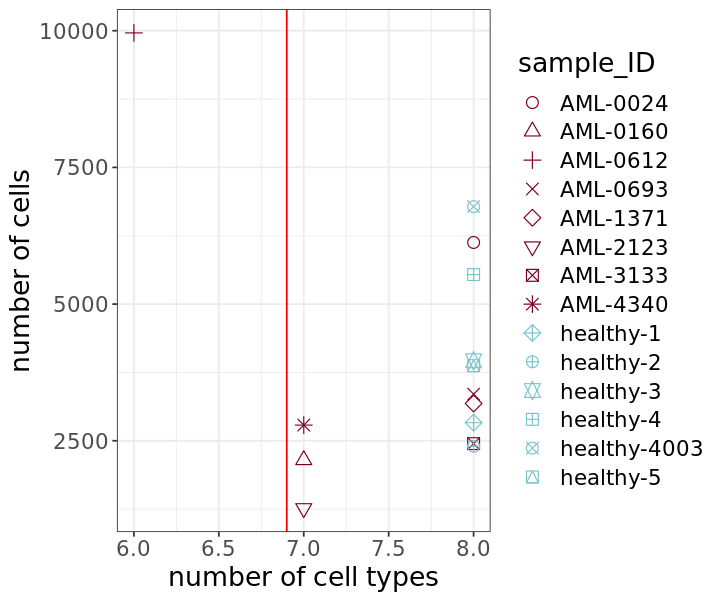

In [88]:
options(repr.plot.width = 6
       ,repr.plot.height = 5)

ggplot(data = anno_samples_cf_ctf_gf
       ,aes(x = nr_celltypes_cf_ctf_gf
            ,y = nr_cells_cf_ctf
            ,color = sample_ID
            ,shape = sample_ID
            ,size = sample_ID
       )
) +
geom_point(size = 3)+
geom_vline(xintercept = threshold_nr_celltypes- 0.1
           ,color = "red")+
scale_color_manual(values = c(rep("#7C001F"
                                 ,8)
                             ,rep("#7ac5cd"
                                 ,6)))+
scale_shape_manual(values=shape_sample)+
scale_size_manual(values=size_sample)+
xlab("number of cell types")+
ylab("number of cells")+
theme_bw()+
theme(text = element_text(size = 16))

In [89]:
#subset anno_anno_samples_cf_ctf_gf

print("dim(anno_samples_cf_ctf_gf) before filtering")
print(dim(anno_samples_cf_ctf_gf))
anno_samples_cf_ctf_gf_sf <- anno_samples_cf_ctf_gf[anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes,]
print("dim(anno_samples_cf_ctf_gf_sf) after filtering")
print(dim(anno_samples_cf_ctf_gf_sf))

[1] "dim(anno_samples_cf_ctf_gf) before filtering"
[1] 14 60
[1] "dim(anno_samples_cf_ctf_gf_sf) after filtering"
[1] 13 60


In [90]:
#subset anno_cells

print("dim(anno_cells_cf_ctf_gf) before filtering")
print(dim(anno_cells_cf_ctf_gf))
idx_bad <- anno_cells_cf_ctf_gf$sample_ID %in% bad_samples
anno_cells_cf_ctf_gf_sf <- anno_cells_cf_ctf_gf[!idx_bad,]
print("dim(anno_cells_cf_ctf_gf_sf) after filtering")
print(dim(anno_cells_cf_ctf_gf_sf))

[1] "dim(anno_cells_cf_ctf_gf) before filtering"
[1] 56662    91
[1] "dim(anno_cells_cf_ctf_gf_sf) after filtering"
[1] 46702    91


In [91]:
#subset counts_cf_ctf_gf

print("dim(counts_cf_ctf_gf) before filtering")
print(dim(counts_cf_ctf_gf))
counts_cf_ctf_gf_sf <- counts_cf_ctf_gf[,!idx_bad]
print("dim(counts_cf_ctf_gf_sf) after filtering")
print(dim(counts_cf_ctf_gf_sf))

[1] "dim(counts_cf_ctf_gf) before filtering"
[1] 15770 56662
[1] "dim(counts_cf_ctf_gf_sf) after filtering"
[1] 15770 46702


In [92]:
anno_cells_cf_ctf_gf_sf$total_counts_raw_cf_ctf_gf_sf <- colSums(counts_cf_ctf_gf_sf)

anno_genes_cf_ctf_gf_sf <- anno_genes_cf_ctf_gf

In [93]:
# visualize expression after sample filter

df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf_gf_sf$total_counts_raw_cf_ctf_gf_sf +1)
                 ,sample_ID = anno_cells_cf_ctf_gf_sf$sample_ID
)
print(str(df))

'data.frame':	46702 obs. of  2 variables:
 $ log10_lib_size: num  3.41 3.41 3.42 3.44 3.45 ...
 $ sample_ID     : chr  "AML-0024" "AML-0024" "AML-0024" "AML-0024" ...
NULL


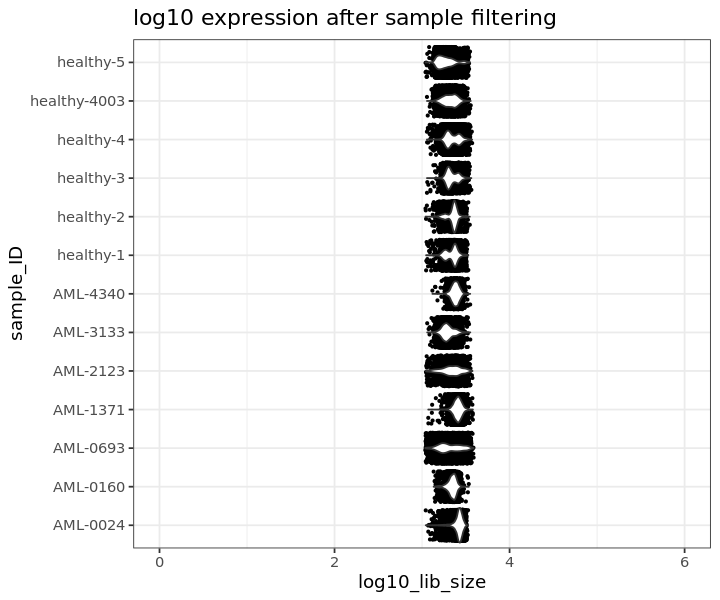

In [94]:
ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL
                    ,size = 0.5) +
        geom_violin() + 
        ggtitle("log10 expression after sample filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

### heatmap

In [95]:
#visualize cell number per cell type per sample

df <- table(data.frame(sample_ID = anno_cells_cf_ctf_gf_sf$sample_ID
                       ,cell_type = anno_cells_cf_ctf_gf_sf$cell_type)
            )
df <- t(matrix(df
               ,ncol = ncol(df)
               ,dimnames=dimnames(df)
               )
        )

In [96]:
library("circlize")

Warning message:
“package ‘circlize’ was built under R version 4.1.3”
circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [97]:
library("ComplexHeatmap")

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [98]:
col_fun = colorRamp2(c(0
                       ,10
                       #,50
                       ,100
                       ,1000
                       , max(df)), c("white"
                                     #,"lightgoldenrod1"
                                     #,"gold"
                                     ,"#CFCFCF"
                                     ,"#BFBFBF"
                                     #,"#A1A1A1"
                                     ,"salmon"
                                     , "darkred"))

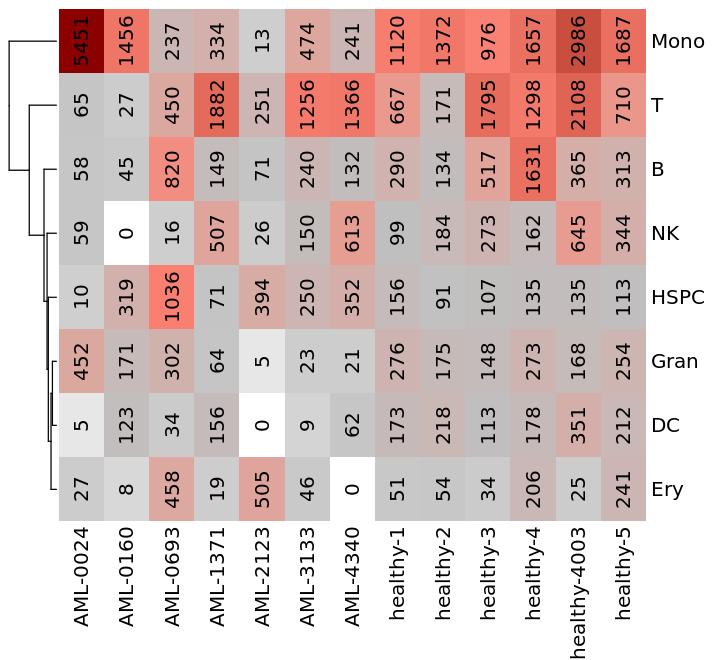

In [99]:
options(repr.plot.width = 6
      ,repr.plot.height = 5.5)
Heatmap(df
        ,cluster_columns = FALSE
        ,col = col_fun
        ,name="nr cells"
        ,show_heatmap_legend = FALSE
        ,cell_fun = function(j, i, x, y, width, height, fill) {
                grid.text(as.character(df[i, j])
                          , x
                          , y
                          , gp = gpar(fontsize = 12
                                      )
                          ,rot=90
                          )
                }
        )

### library size by cell type

In [100]:
cell_type_IDs <- unique(anno_cells_cf_ctf_gf_sf$cell_type_ID)
counts_filtered_pseudobulkCellType <- as.data.frame(matrix(,nrow = nrow(counts_cf_ctf_gf_sf)
                                                    ,ncol = length(cell_type_IDs)
))

i <- 1
for(cell_type_ID in cell_type_IDs){
        
        idx_cell_type_ID <- anno_cells_cf_ctf_gf_sf$cell_type_ID == cell_type_ID
        
        if(sum(idx_cell_type_ID) == 0){
                counts_filtered_pseudobulkCellType[,i] <- 0
        } else if( sum(idx_cell_type_ID) == 1){
                counts_filtered_pseudobulkCellType[,i] <- counts_cf_ctf_gf_sf[,idx_cell_type_ID]
        } else {
                counts_filtered_pseudobulkCellType[,i] <- rowMeans(counts_cf_ctf_gf_sf[,idx_cell_type_ID])
        }
        
        i <- i+1
}

colnames(counts_filtered_pseudobulkCellType) <- cell_type_IDs
rownames(counts_filtered_pseudobulkCellType) <- rownames(counts_cf_ctf_gf_sf)
cat("str(counts_filtered_pseudobulkCellType\n\n)")
print(str(counts_filtered_pseudobulkCellType))

str(counts_filtered_pseudobulkCellType

)'data.frame':	15770 obs. of  101 variables:
 $ Mono_AML-0024    : num  0.01033 0.02362 0.02033 0.00855 0.01374 ...
 $ Gran_AML-0024    : num  0.00906 0.04669 0.02804 0.00546 0.02244 ...
 $ T_AML-0024       : num  0 0.0175 0 0.0245 0 ...
 $ NK_AML-0024      : num  0 0.0484 0.0319 0 0 ...
 $ B_AML-0024       : num  0 0.0232 0.0427 0.0487 0.0388 ...
 $ HSPC_AML-0024    : num  0 0.0599 0.0485 0 0 ...
 $ Ery_AML-0024     : num  0 0 0.3 0 0.0576 ...
 $ DC_AML-0024      : num  0 0.16 0 0 0 ...
 $ Mono_AML-0160    : num  0.00817 0.09462 0.0178 0.00796 0.0173 ...
 $ DC_AML-0160      : num  0 0.11685 0.00801 0.01498 0.01268 ...
 $ Gran_AML-0160    : num  0.00702 0.10064 0.01733 0.01086 0.02891 ...
 $ HSPC_AML-0160    : num  0.01053 0.05027 0.07866 0.00618 0.02424 ...
 $ B_AML-0160       : num  0 0.0827 0 0 0 ...
 $ Ery_AML-0160     : num  0 0 0.578 0 0 ...
 $ T_AML-0160       : num  0 0 0 0 0.0629 ...
 $ Ery_AML-0693     : num  0.01371 0.047799 0.203863 0

In [101]:
# visualize expression in pseudo sorted bulk

my_sampes <- sub("_.*", "", colnames(counts_filtered_pseudobulkCellType))
df <- data.frame(log10_lib_size = log10(colSums(counts_filtered_pseudobulkCellType) +1)
                 ,sample_ID = sub(".*_"
                                  ,""
                                  ,colnames(counts_filtered_pseudobulkCellType)
                 )
                 ,cell_type = sub("_.*"
                                   ,""
                                   ,colnames(counts_filtered_pseudobulkCellType)
                 )
)

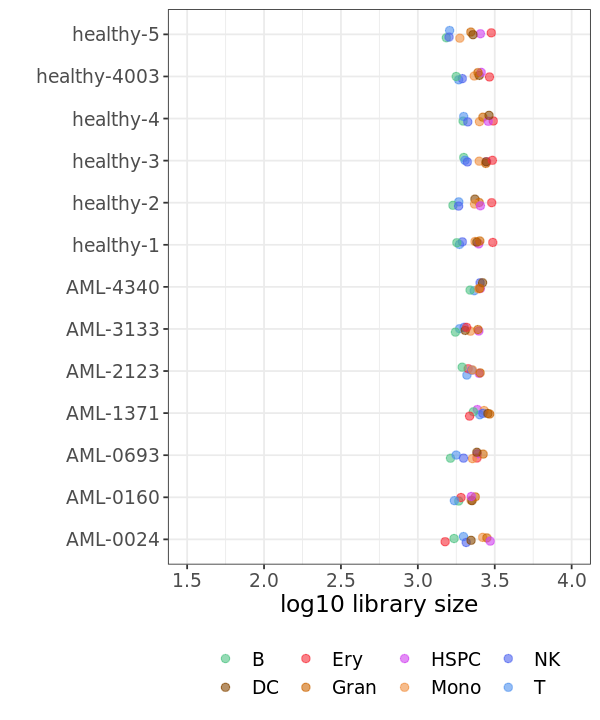

In [102]:
options(repr.plot.width=5
        , repr.plot.height=6) 
ggplot(data = df
             ,aes(y = sample_ID
                  ,x = log10_lib_size
                  ,color = cell_type
             )
) +
geom_jitter(height = 0.1
            ,width = 0
            ,alpha = 0.6
           ,size =2) +
xlim(c(1.5,4))+
ylab("")+
scale_color_manual(values = color_celltype
                  ,name = "")+
theme_bw()+
xlab("log10 library size")+
theme(text = element_text(size = 14)
     ,legend.position = "bottom")

In [103]:
str(anno_genes_cf_ctf_gf_sf)

'data.frame':	15770 obs. of  7 variables:
 $ gene_symbol                          : chr  "AL627309.5" "LINC01409" "LINC01128" "LINC00115" ...
 $ is_in_LR_database                    : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ isLigand                             : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ isReceptor                           : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ sum_pseudobulkCellType_expr          : num  0.747 6.605 6.464 1.13 2.48 ...
 $ sum_pseudobulkCellType_expr_threshold: num  0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...
 $ sum_pseudobulkCellType_expr_filter   : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


In [104]:
cell_type_IDs <- unique(anno_cells_cf_ctf_gf_sf$cell_type_ID)
idx_ligrec <- anno_genes_cf_ctf_gf_sf$isLigand | anno_genes_cf_ctf_gf_sf$isReceptor
counts_ligrec_pseudobulkCellType <- as.data.frame(matrix(,nrow = sum(idx_ligrec)
                                                    ,ncol = length(cell_type_IDs)
))

i <- 1
for(cell_type_ID in cell_type_IDs){
        
        idx_cell_type_ID <- anno_cells_cf_ctf_gf_sf$cell_type_ID == cell_type_ID
        
        if(sum(idx_cell_type_ID) == 0){
                counts_ligrec_pseudobulkCellType[,i] <- 0
        } else if( sum(idx_cell_type_ID) == 1){
                counts_ligrec_pseudobulkCellType[,i] <- counts_cf_ctf_gf_sf[idx_ligrec,idx_cell_type_ID]
        } else {
                counts_ligrec_pseudobulkCellType[,i] <- rowMeans(counts_cf_ctf_gf_sf[idx_ligrec,idx_cell_type_ID])
        }
        
        i <- i+1
}

colnames(counts_ligrec_pseudobulkCellType) <- cell_type_IDs
rownames(counts_ligrec_pseudobulkCellType) <- rownames(counts_cf_ctf_gf_sf)[idx_ligrec]
cat("str(counts_ligrec_pseudobulkCellType\n\n)")
print(str(counts_ligrec_pseudobulkCellType))

str(counts_ligrec_pseudobulkCellType

)'data.frame':	1254 obs. of  101 variables:
 $ Mono_AML-0024    : num  0.01432 0.00169 0.00231 0.55163 0.00845 ...
 $ Gran_AML-0024    : num  0.01408 0.00891 0.00256 0.59248 0.0123 ...
 $ T_AML-0024       : num  0 0.043 0.059 0.3582 0.0306 ...
 $ NK_AML-0024      : num  0 0.4358 0.1455 0.4461 0.0267 ...
 $ B_AML-0024       : num  0 0 0 0.2089 0.0505 ...
 $ HSPC_AML-0024    : num  0.0201 0 0.0442 0.7072 0 ...
 $ Ery_AML-0024     : num  0.0527 0 0 0.2895 0 ...
 $ DC_AML-0024      : num  0 0.124 0 0.762 0 ...
 $ Mono_AML-0160    : num  0.00141 0 0.00601 0.54647 0.00497 ...
 $ DC_AML-0160      : num  0 0 0 0.47 0 ...
 $ Gran_AML-0160    : num  0 0.00697 0 0.55995 0 ...
 $ HSPC_AML-0160    : num  0.00202 0 0.00662 0.40348 0.01934 ...
 $ B_AML-0160       : num  0 0 0.0381 0.3151 0.1338 ...
 $ Ery_AML-0160     : num  0 0 0 0.136 0 ...
 $ T_AML-0160       : num  0 0 0 0.15 0 ...
 $ Ery_AML-0693     : num  1.97e-02 3.21e-03 6.61e-04 3.39e-01 1.32e-05 ...
 $

In [105]:
# visualize expression in pseudo sorted bulk

my_sampes <- sub("_.*", "", colnames(counts_ligrec_pseudobulkCellType))
df <- data.frame(log10_lib_size = log10(colSums(counts_ligrec_pseudobulkCellType) +1)
                 ,sample_ID = sub(".*_"
                                  ,""
                                  ,colnames(counts_ligrec_pseudobulkCellType)
                 )
                 ,cell_type = sub("_.*"
                                   ,""
                                   ,colnames(counts_ligrec_pseudobulkCellType)
                 )
)

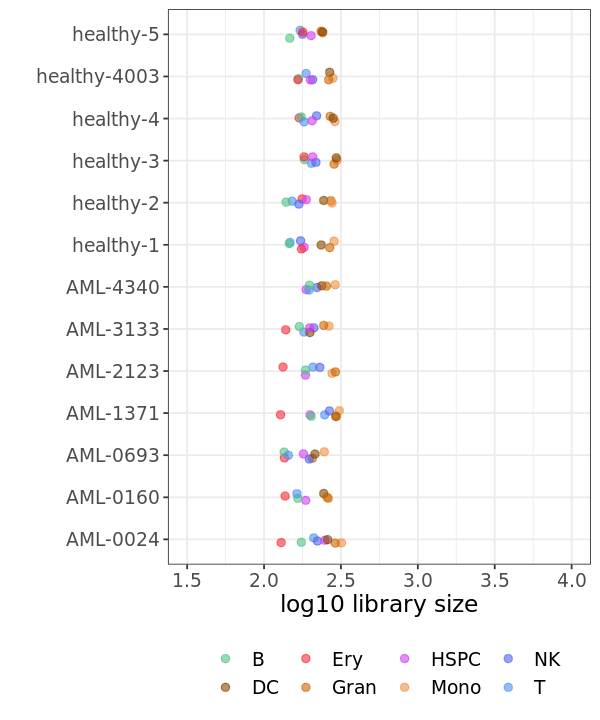

In [106]:
options(repr.plot.width=5
        , repr.plot.height=6) 
ggplot(data = df
             ,aes(y = sample_ID
                  ,x = log10_lib_size
                  ,color = cell_type
             )
) +
geom_jitter(height = 0.1
            ,width = 0
            ,alpha = 0.6
           ,size =2) +
xlim(c(1.5,4))+
ylab("")+
scale_color_manual(values = color_celltype
                  ,name = "")+
theme_bw()+
xlab("log10 library size")+
theme(text = element_text(size = 14)
     ,legend.position = "bottom")

### export

Since the data is already normalized, we will export it with the tag "norm"

In [107]:
dim(counts_cf_ctf_gf_sf)

[1] 15770 46702

In [108]:
dim(anno_cells_cf_ctf_gf_sf)

[1] 46702    92

In [1]:
#no log transformation

In [109]:
#save without logtransformation
write.table(data.frame("gene_symbol"=rownames(counts_cf_ctf_gf_sf),counts_cf_ctf_gf_sf),
            gzfile("outs/counts_norm.csv.gz"), row.names=FALSE)

In [110]:
# log_transformed_counts <- log1p(counts_cf_ctf_gf_sf)

In [114]:
# write.table(data.frame("gene_symbol"=rownames(log_transformed_counts),log_transformed_counts),
#             gzfile("outs/counts_norm_log_transformed.csv.gz"), row.names=FALSE)

In [115]:
# save counts
# library(Matrix)
# writeMM(obj = Matrix(as.matrix(counts_cf_ctf_gf_sf)
#                      , sparse=TRUE)
#         , file = "outs/counts_norm.mtx"
#         )

# export anno_cells
write.table(anno_cells_cf_ctf_gf_sf
            ,file = "outs/anno_cells_norm.txt"
             ,sep = "\t"
            ,row.names = FALSE )


# export anno_genes
write.table(anno_genes_cf_ctf_gf_sf
            ,file = "outs/anno_genes_norm.txt"
            ,sep = "\t"
            ,row.names = FALSE
)

# export anno_samples
write.table(anno_samples_cf_ctf_gf_sf
            ,file = "outs/anno_samples_norm.txt"
            ,sep = "\t"
            ,row.names = FALSE
)

NULL